## Analysis of $H_Q$ with respect to the exact ground state for the sd and pf shells

#### Imports

In [1]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
from cupyx.scipy.sparse.linalg import eigsh as eigsh_cp

file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)



nparts=[(2,0),(4,0),(6,0),(8,0),(2,2),(4,2),(6,2),(8,2),(4,4),(6,4),(8,4),(6,6),(8,6),(10,6)]
titles=[r'$^{18}$O',r'$^{20}$O',r'$^{22}$O',r'$^{24}$O',r'$^{20}$Ne',r'$^{22}$Ne',r'$^{24}$Ne',r'$^{26}$Ne',r'$^{24}$Mg',r'$^{26}$Mg',r'$^{28}$Mg',r'$^{28}$Si',r'$^{30}$Si',r'$^{32}$Si']

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [2]:
# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    gpu_hamiltonian=cp_csr_matrix(NSMHamiltonian.hamiltonian)
    egs,psi0=eigsh_cp(gpu_hamiltonian,k=1,which='SA')

    print(egs)
    QPC=QuasiParticlesConverterOnlynnpp()

    QPC.initialize_shell(state_encoding=SPS.state_encoding)


    #just for the basis
    QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
    
    hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
    
    gpu_hamiltonian_qq=cp_csr_matrix(hamiltonian_qq)
    egs_qq,psi_q=eigsh_cp(gpu_hamiltonian_qq,k=1,which='SA')
    
    psi_q=QPC.particles2quasiparticles.T @ psi_q[:,0].get()
    delta=np.abs((egs_qq[0].get()-egs[0].get())/egs[0].get())
    energy_errors.append(delta)
    
    fidelity=(psi_q[:].dot(psi0[:,0].get())).conjugate()*(psi_q[:].dot(psi0[:,0].get()))
    fidelities.append(1-fidelity.item())
    

size= 24 12
[-11.93178825]
size= 24 12
[-23.93429271]
size= 24 12
[-35.26713604]
size= 24 12
[-42.346228]
size= 24 12
[-41.39649007]
size= 24 12
[-59.93848563]
size= 24 12
[-75.70058627]
size= 24 12
[-87.14199175]
size= 24 12
[-92.77520307]
size= 24 12
[-114.07487317]
size= 24 12
[-132.37718673]
size= 24 12
[-149.78217307]
size= 24 12
[-173.25149659]
size= 24 12
[-194.36314036]


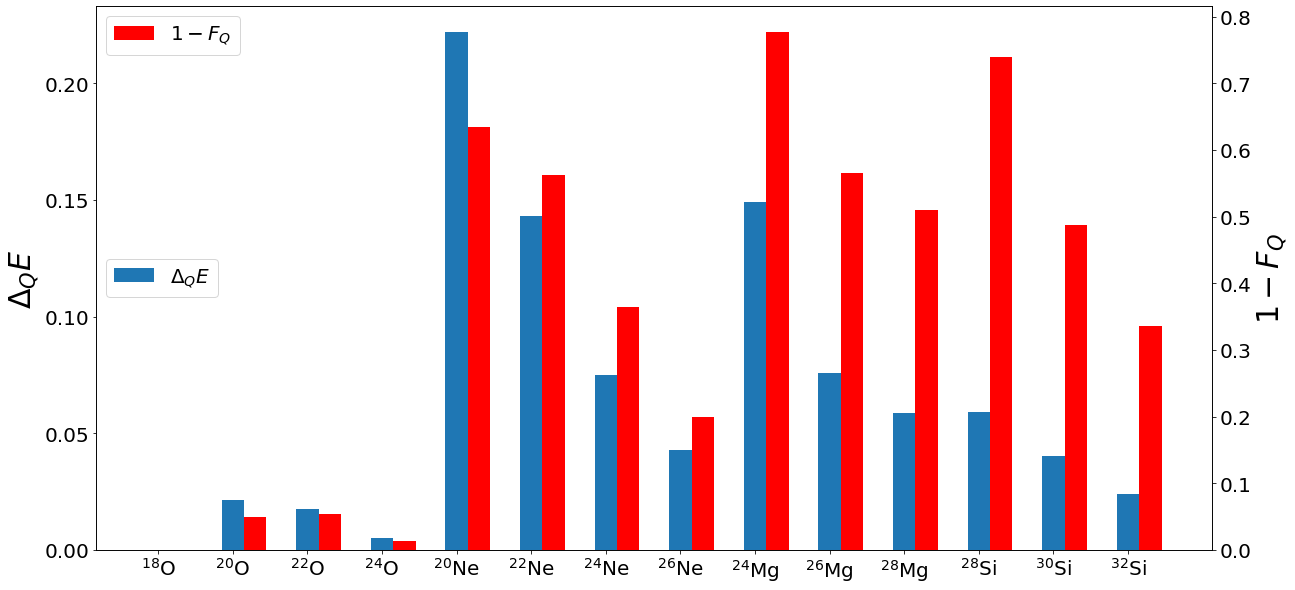

In [3]:
fig,ax=plt.subplots(figsize=(20,10))
ax.bar(x=np.arange(len(titles)),height=energy_errors,width=0.3,label=r'$\Delta_Q E$')
ax_twin=ax.twinx()
ax_twin.bar(x=np.arange(len(titles))+0.3,height=fidelities,color='red',width=0.3,label=r'$1-F_Q$')
plt.xticks(np.arange(len(titles)),titles)
ax.legend(fontsize=20,loc='center left')
ax_twin.legend(fontsize=20,loc='upper left')
ax.tick_params(which='major',labelsize=20)
ax_twin.tick_params(which='major',labelsize=20)
ax.set_ylabel(r'$\Delta_Q E$',fontsize=30)
ax_twin.set_ylabel(r'$1-F_Q$',fontsize=30)

plt.show()

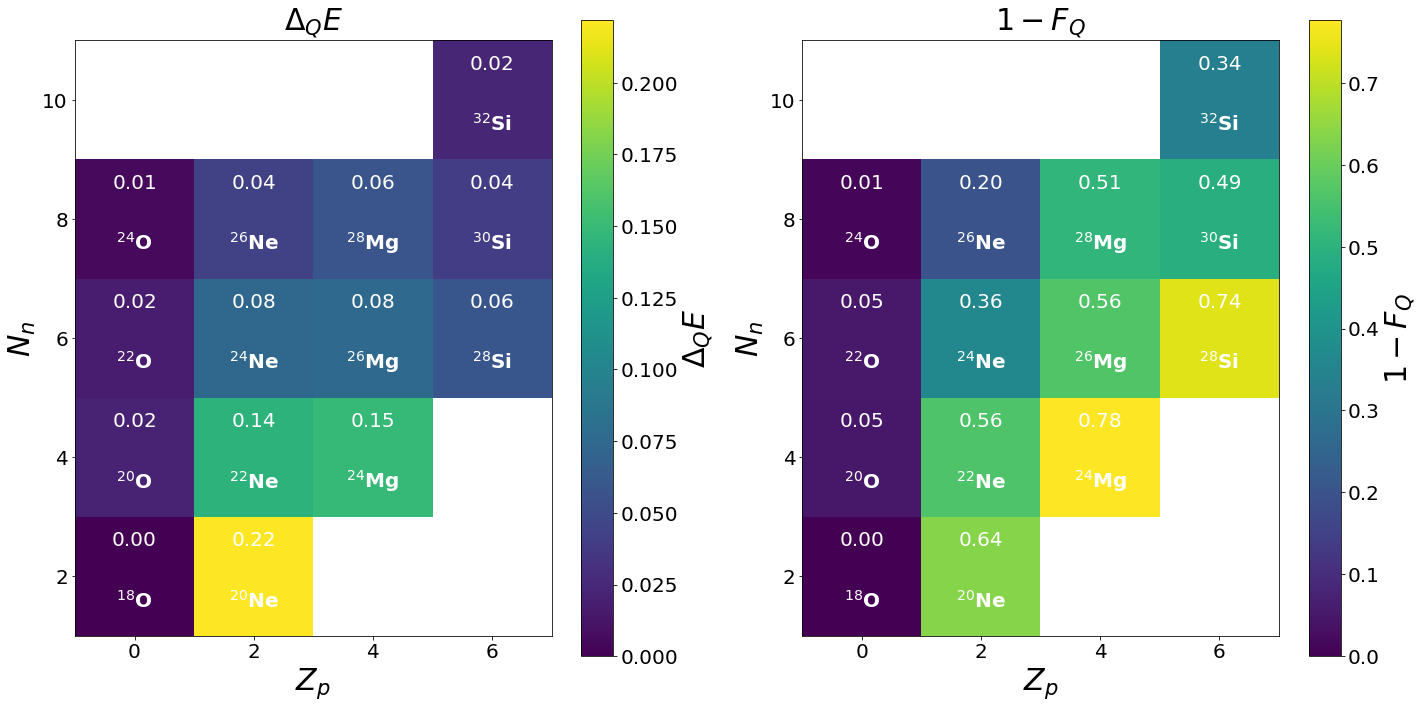

In [ ]:
# Dummy data (replace with your real energy_errors or fidelities)
values = energy_errors  # Or use energy_errors or fidelities

# Get all even values for proton/neutron
protons = sorted(set(p for n, p in nparts))
neutrons = sorted(set(n for n, p in nparts))

# Create mapping from proton/neutron count to index
p_idx = {p: i for i, p in enumerate(protons)}
n_idx = {n: i for i, n in enumerate(neutrons)}

# Create matrix
matrix = np.full((len(neutrons), len(protons)), np.nan)  # NaN for no data

# Fill matrix with values at valid (n, p)
for (n, p), val in zip(nparts, values):
    matrix[n_idx[n], p_idx[p]] = val

# Plotting
fig, ax = plt.subplots(2,1,figsize=(10, 20))
cax = ax[0].imshow(matrix, cmap='viridis', origin='lower')

# Axis ticks and labels
ax[0].set_xticks(np.arange(len(protons)))
ax[0].set_yticks(np.arange(len(neutrons)))
ax[0].set_xticklabels(protons, fontsize=14)
ax[0].set_yticklabels(neutrons, fontsize=14)
ax[0].set_xlabel(r"$Z_p$", fontsize=30)
ax[0].set_ylabel(r"$N_n$", fontsize=30)

# Overlay values and names
for (n, p), title, val in zip(nparts, titles, values):
    i = n_idx[n]
    j = p_idx[p]
    if not np.isnan(val):
        ax[0].text(j, i - 0.2, f"{title}", ha='center', va='center', color='white', fontsize=20, weight='bold')
        ax[0].text(j, i + 0.3, f"{val:.2f}", ha='center', va='center', color='white', fontsize=20)

# Add colorbar
cbar = fig.colorbar(cax, ax=ax[0])
cbar.set_label(r'$\Delta_Q E$', fontsize=30)
ax[0].set_title(r'$\Delta_Q E$',fontsize=30)
cbar.ax.tick_params(labelsize=20)
values = fidelities  # Or use energy_errors or fidelities

# Get all even values for proton/neutron
protons = sorted(set(p for n, p in nparts))
neutrons = sorted(set(n for n, p in nparts))

# Create mapping from proton/neutron count to index
p_idx = {p: i for i, p in enumerate(protons)}
n_idx = {n: i for i, n in enumerate(neutrons)}

# Create matrix
matrix = np.full((len(neutrons), len(protons)), np.nan)  # NaN for no data

# Fill matrix with values at valid (n, p)
for (n, p), val in zip(nparts, values):
    matrix[n_idx[n], p_idx[p]] = val

# Plotting

cax = ax[1].imshow(matrix, cmap='viridis', origin='lower')

# Axis ticks and labels
ax[1].set_xticks(np.arange(len(protons)))
ax[1].set_yticks(np.arange(len(neutrons)))
ax[1].set_xticklabels(protons, fontsize=14)
ax[1].set_yticklabels(neutrons, fontsize=14)
ax[1].set_xlabel(r"$Z_p$", fontsize=30)
ax[1].set_ylabel(r"$N_n$", fontsize=30)

# Overlay values and names
for (n, p), title, val in zip(nparts, titles, values):
    i = n_idx[n]
    j = p_idx[p]
    if not np.isnan(val):
        ax[1].text(j, i - 0.2, f"{title}", ha='center', va='center', color='white', fontsize=20, weight='bold')
        ax[1].text(j, i + 0.3, f"{val:.2f}", ha='center', va='center', color='white', fontsize=20)
ax[1].set_title(r'$1-F_Q$',fontsize=30)
# Add colorbar
cbar = fig.colorbar(cax, ax=ax[1])
cbar.set_label(r'$1-F_Q$', fontsize=30)
cbar.ax.tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20)
plt.tight_layout()
plt.show()

### Pf Shell Case

#### Imports

In [25]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
from cupyx.scipy.sparse.linalg import eigsh as eigsh_cp

file_name='data/gxpf1a'

SPS=SingleParticleState(file_name=file_name)



nparts=[(2,0),(4,0),(6,0),(8,0),(10,0),(2,2)]
titles=[r'$^{42}$Ca',r'$^{44}$Ca',r'$^{46}$Ca',r'$^{48}$Ca',r'$^{50}$Ca',r'$^{44}$Ti']

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [26]:
# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator
energy_errors=[]
fidelities=[]
for idx,npart in enumerate(nparts):
    nparticles_a,nparticles_b=npart
    title=titles[idx]
    
    # compute the NSM Hamiltonian
    NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
    print('size=',size_a+size_b,size_b)
    NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
    if file_name=='data/cki':
        twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

        NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    else:
        NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/gxpf1a_{nparticles_a}_{nparticles_b}.npz')
    NSMHamiltonian.get_hamiltonian()

    gpu_hamiltonian=cp_csr_matrix(NSMHamiltonian.hamiltonian)
    egs,psi0=eigsh_cp(gpu_hamiltonian,k=1,which='SA')

    print(egs)
    QPC=QuasiParticlesConverterOnlynnpp()

    QPC.initialize_shell(state_encoding=SPS.state_encoding)


    #just for the basis
    QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
    
    hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
    
    gpu_hamiltonian_qq=cp_csr_matrix(hamiltonian_qq)
    egs_qq,psi_q=eigsh_cp(gpu_hamiltonian_qq,k=1,which='SA')
    
    psi_q=QPC.particles2quasiparticles.T @ psi_q[:,0].get()
    delta=np.abs((egs_qq[0].get()-egs[0].get())/egs[0].get())
    energy_errors.append(delta)
    
    fidelity=(psi_q[:].dot(psi0[:,0].get())).conjugate()*(psi_q[:].dot(psi0[:,0].get()))
    fidelities.append(1-fidelity.item())
    

size= 40 20
[-19.73367578]
size= 40 20
[-38.74112048]
size= 40 20
[-56.82059266]
size= 40 20
[-73.87226855]
size= 40 20
[-85.35155886]
size= 40 20
[-47.79419593]


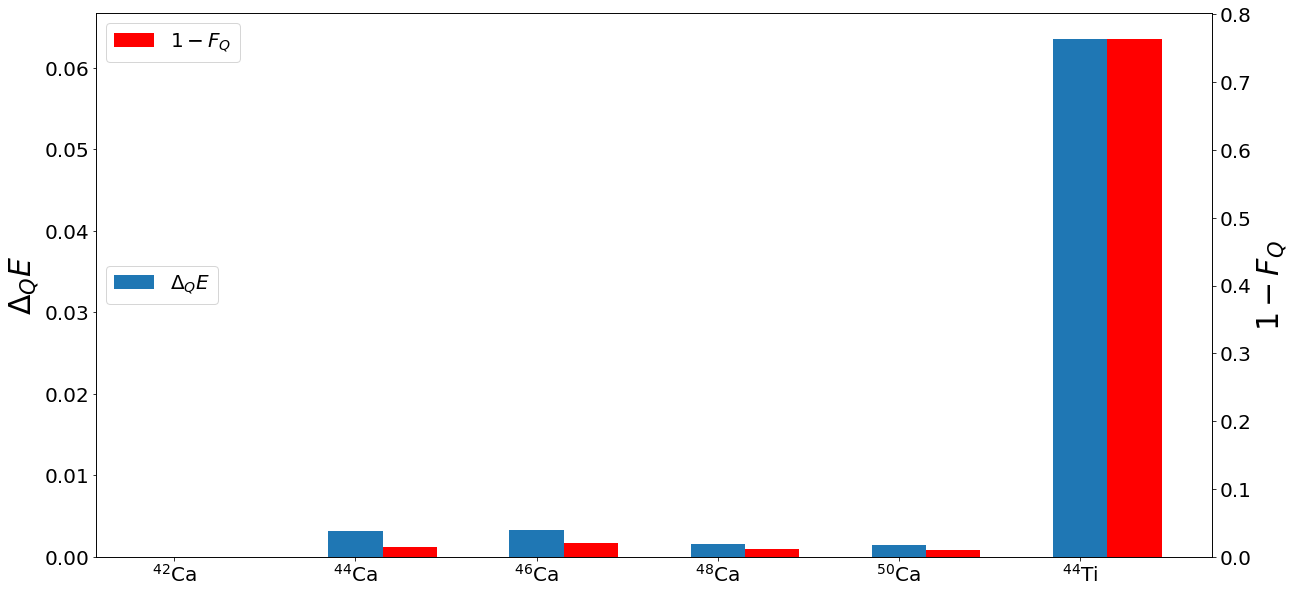

In [ ]:
# Assuming energy_errors, fidelities, titles are already defined
fig, ax = plt.subplots(figsize=(10, 20))  # Swap width and height

y_pos = np.arange(len(titles))

# Main horizontal bars
ax.barh(y=y_pos, width=energy_errors, height=0.3, label=r'$\Delta_Q E$')

# Twin axis for the second set of bars
ax_twin = ax.twiny()
ax_twin.barh(y=y_pos + 0.3, width=fidelities, height=0.3, color='red', label=r'$1-F_Q$')

# Set y-ticks to titles
plt.yticks(y_pos, titles)

# Legends
ax.legend(fontsize=20, loc='lower right')
ax_twin.legend(fontsize=20, loc='upper right')

# Tick and label formatting
ax.tick_params(which='major', labelsize=20)
ax_twin.tick_params(which='major', labelsize=20)
ax.set_xlabel(r'$\Delta_Q E$', fontsize=30)
ax_twin.set_xlabel(r'$1-F_Q$', fontsize=30)

plt.tight_layout()
plt.show()

## Analysis of $H_{eff}$

In [1]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'

In [2]:

# Compute the J^2 value
J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)
print(NSMHamiltonian.basis)
print(NSMHamiltonian.hamiltonian)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

100%|██████████| 24/24 [00:30<00:00,  1.28s/it]
3624it [00:20, 173.61it/s]


size= 24 12
[-41.39649007]
[[1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
  (np.int32(0), np.int32(0))	-21.637774603174606
  (np.int32(0), np.int32(1))	2.1441927358413584
  (np.int32(0), np.int32(2))	-0.10915079365079428
  (np.int32(0), np.int32(3))	-0.6398020847719197
  (np.int32(0), np.int32(4))	0.3682345247093515
  (np.int32(0), np.int32(5))	0.5211067201086399
  (np.int32(0), np.int32(6))	-0.9690507936507938
  (np.int32(0), np.int32(7))	0.22802569399122857
  (np.int32(0), np.int32(9))	-0.632878191158204
  (np.int32(0), np.int32(10))	0.45225308401658526
  (np.int32(0), np.int32(11))	0.2665777205429144
  (np.int32(0), np.int32(12))	-1.2129704215656378
  (np.int32(0), np.int32(15))	-0.5542253968253976
  (np.int32(0), np.int32(16))	0.43082268503532073
  (np.int32(0), np.int32(20))	0.03468810059641142
  (np.int32(0), np.int32(21))	0.2890940607855491
  (np.int32(0), np.int32(22))	-0.2239312965819814
  (np.int32(0), n

In [6]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T

j2_qq=QPC.particles2quasiparticles @ J2Class.hamiltonian @ QPC.particles2quasiparticles.T

values,psi_qq=eigsh(hamiltonian_qq,k=1,which='SA')

In [9]:
data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_20Ne.npz',allow_pickle=True)

psis=data['psi']
energies=data['energy']
final_hamiltonian=data['final_effective_hamiltonian']


In [10]:

print(psis[-1].conjugate().dot(j2_qq.dot(psis[-1])))

0.5490167572089547


In [11]:
effective_final_psi=QPC.particles2quasiparticles.T @ psis[-1][:]
psi_qq_in_the_full_basis=QPC.particles2quasiparticles.T @ psi_qq[:,0]

In [12]:
print(effective_final_psi.shape,psi0.shape)

(640,) (640, 1)


In [13]:
print(J2Class.j_value(psi=effective_final_psi))

()
0.39387737257912214


In [110]:
print((effective_final_psi.dot(psi0[:,0])*np.conjugate(effective_final_psi.dot(psi0[:,0]))))

0.28671977838779644


In [79]:
data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_20O.npz',allow_pickle=True)
errors_o20=data['errors']
title_o20=data['title']

data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_20Ne.npz',allow_pickle=True)
errors_ne20=data['errors']
title_ne20=data['title']

data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_24Mg.npz',allow_pickle=True)
errors_mg24=data['errors']
title_mg24=data['title']

data=np.load('data/effective_hamiltonian_method_larger_reduction/effective_hamiltonian_method_28Si.npz',allow_pickle=True)
errors_si28=data['errors']
title_si28=data['title']


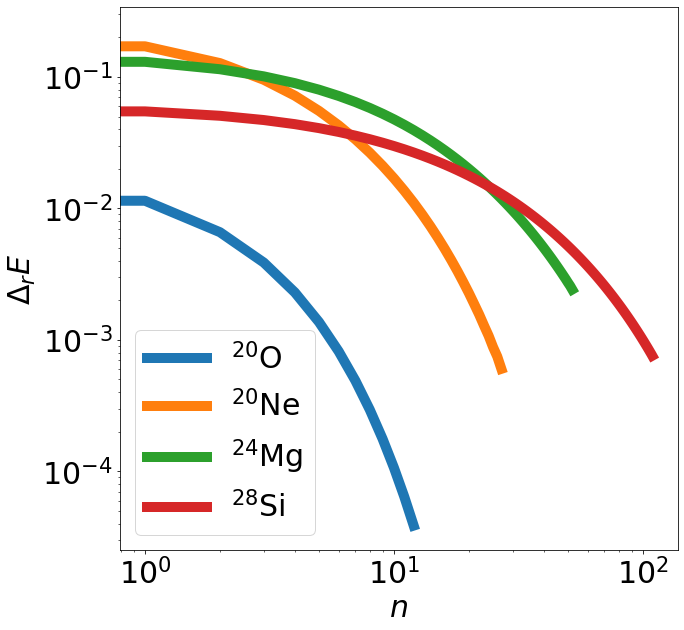

In [80]:
plt.figure(figsize=(10,10))
plt.plot(errors_o20,label=title_o20,linewidth=10)
plt.plot(errors_ne20,label=title_ne20,linewidth=10)
plt.plot(errors_mg24,label=title_mg24,linewidth=10)
plt.plot(errors_si28,label=title_si28,linewidth=10)
plt.loglog()
plt.tick_params(labelsize=30)
plt.xlabel(r'$n$',fontsize=30)
plt.ylabel(r'$\Delta_r E$',fontsize=30)
plt.legend(fontsize=30)
plt.show()